# Model for Age and Gender Detection

**Import Necessary Libraries**

In [1]:
import warnings

# Filter out DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import tensorflow as tf
import cv2 as cv2
import numpy as np 
import matplotlib.pyplot as plt
import os

from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Conv2D
from tensorflow.keras.layers import Input, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, Adamax, RMSprop

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Extract data from the dataset**

In [3]:
fldir = '/kaggle/input/utkface-new/UTKFace'
files = os.listdir(fldir)

**Creating a list of images**

In [4]:
images = []

for file in files:
    total = fldir + '/' + file
    # print(total)
    image = cv2.imread(total)

    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (48, 48))
        images.append(image)
    else:
        print("Error: Unable to load the image.", file)


**Creating a list of Age and Gender**

In [5]:
ages = []
genders = []

for file in files:
    age = int(file.split('_')[0])
    gender = int(file.split('_')[1])

    ages.append(age)
    genders.append(gender)

**Showing a sample**

3
1


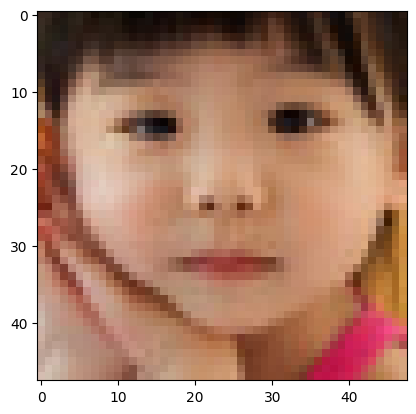

In [6]:
print(ages[100])
print(genders[100])
plt.imshow(images[100])

**Converting the images, ages and genders to numpy array and saving in the system**

In [7]:
images_f = np.array(images)
ages_f = np.array(ages)
genders_f = np.array(genders)

In [8]:
np.save('/kaggle/working/images.npy', images_f)
np.save('/kaggle/working/ages.npy', ages_f)
np.save('/kaggle/working/genders.npy', genders_f)

**Finding number of elements in the dataset**

In [9]:
gen_values, gen_counts = np.unique(genders_f, return_counts = True)
age_values, age_counts = np.unique(ages_f, return_counts = True)
print(gen_counts, "\n" , age_counts)

[12391 11317] 
 [1123  482  289  273  196  131  139  263  166  156   65  130   81  157
  177  247  158  262   98  284  346  395  426  859  734 2197  615  918
  570  724  350  664  143  409  880  483  293  325  266  526  132  266
  157  100  440  153  170  153  148  381  138  232  241  353  268  236
   97  271   82  293  161  125  103   50  259   77   94  100   56  147
   33   98   63   32  148   58   28   69   23  133   22   40   18   24
  155   35   10   34   33   82    2   13    5    9   17    9   11    2
    1    5    5    1    3    4]


## Plotting

**Number of Male and Female Samples**

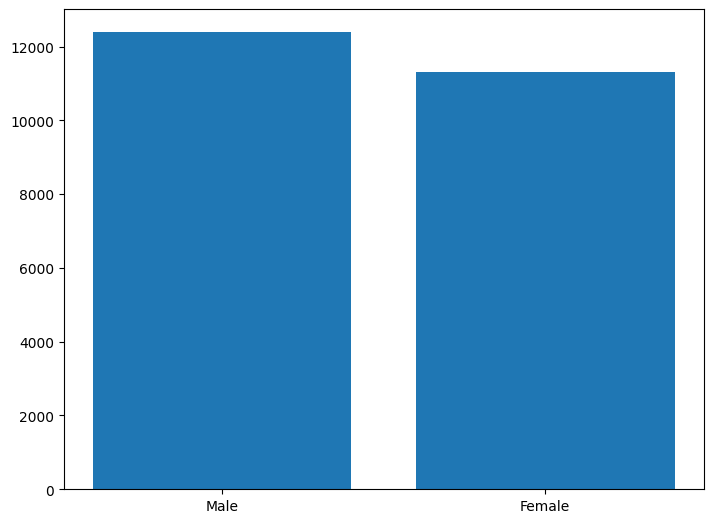

In [10]:
ax = plt.figure().add_axes([0, 0, 1, 1])
sex = ['Male', 'Female']
ax.bar(sex, gen_counts)
plt.show()

**Number of samples in each age**

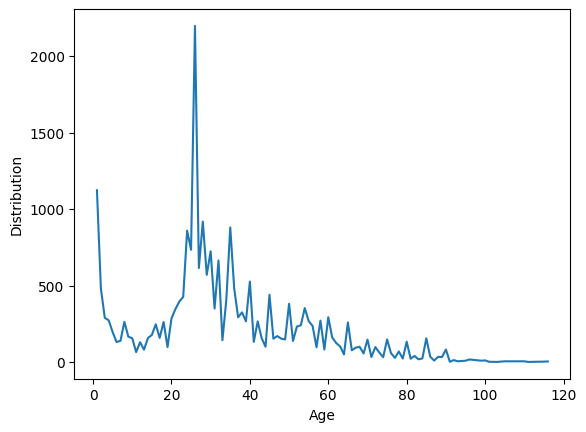

In [11]:
plt.plot(age_values, age_counts)
plt.xlabel('Age')
plt.ylabel('Distribution')
plt.show()

## Defining labels for output

In [12]:
labels = []
i = 0
while(i<len(ages)):
    label = []
    label.append(ages[i])
    label.append(genders[i])
    labels.append(label)
    i += 1

**Creating new image list for better learning**

In [13]:
images_f2 = images_f/255
images_f2.shape

(23708, 48, 48, 3)

In [14]:
labels_f = np.array(labels)
np.save('/kaggle/working/labels.npy', labels_f)

## Splitting the dataset into training and test datasets

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_f2, labels_f, test_size = 0.25, random_state = 42)

In [16]:
y_train[0:5]

array([[ 8,  1],
       [47,  0],
       [38,  0],
       [23,  0],
       [32,  1]])

**Splitting the 'y_train' and 'y_test' into further for better understanding**


***For acquiring gender and age seperately***

In [17]:
y_train2 = [y_train[:,1], y_train[:,0]]
y_test2 = [y_test[:,1], y_test[:,0]]
y_train2[1][0:5]

array([ 8, 47, 38, 23, 32])

## Defining the Model

In [18]:
def Convulation(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same", strides = (1,1), kernel_regularizer = l2(0.001))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)

    return x

In [19]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)

    return x

In [20]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convulation(inputs, 32, (3,3))
    conv_2 = Convulation(conv_1, 64, (3,3))
    conv_3 = Convulation(conv_2, 128, (3,3))
    conv_4 = Convulation(conv_3, 256, (3,3))
    conv_5 = Convulation(conv_4, 512, (3,3))

    flatten = Flatten()(conv_5)
    dense_1 = Dense_f(flatten, 64)
    dense_2 = Dense_f(flatten, 64)

    output_1 = Dense(1, activation = 'sigmoid', name = 'sex_out')(dense_1)
    output_2 = Dense(1, activation = 'relu', name = 'age_out')(dense_2)
    model = Model(inputs = [inputs], outputs = [output_1, output_2])
    
    opt = Adam(lr = 0.01)

    model.compile(loss = ['binary_crossentropy', 'mae'], optimizer = opt, metrics = ['accuracy'])
    return model

**Summary of the Model**

In [21]:
model = model_fer((48, 48, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 48, 48, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 48, 48, 32)           0         ['batch_normalization[0][0

## Initializing Model

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpint_path = "/kaggle/working/model_weights.h5"
checkpoint = ModelCheckpoint(checkpint_path, monitor = "val_loss", save_best_only = True, save_weights_only = False, mode = "auto", verbose = 1, save_freq ='epoch')
Early_stop = tf.keras.callbacks.EarlyStopping(patience = 25, monitor = 'val_loss', restore_best_weights = 'True')
callback_list = [checkpoint, Early_stop]

## Running the Model
### Takes some time to run

In [23]:
History = model.fit(X_train, y_train2, batch_size = 64, validation_data = (X_test, y_test2), epochs = 250, callbacks = callback_list)

Epoch 1/250


2023-12-27 11:09:45.467422: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


278/278 [==============================] - ETA: 0s - loss: 28.4606 - sex_out_loss: 0.5568 - age_out_loss: 27.2848 - sex_out_accuracy: 0.7123 - age_out_accuracy: 0.0074
Epoch 1: val_loss improved from inf to 32.93723, saving model to /kaggle/working/model_weights.h5
278/278 [==============================] - 17s 19ms/step - loss: 28.4606 - sex_out_loss: 0.5568 - age_out_loss: 27.2848 - sex_out_accuracy: 0.7123 - age_out_accuracy: 0.0074 - val_loss: 32.9372 - val_sex_out_loss: 0.6514 - val_age_out_loss: 31.6891 - val_sex_out_accuracy: 0.5715 - val_age_out_accuracy: 5.0616e-04
Epoch 2/250
  1/278 [..............................] - ETA: 4s - loss: 23.6005 - sex_out_loss: 0.4007 - age_out_loss: 22.6031 - sex_out_accuracy: 0.8281 - age_out_accuracy: 0.0000e+00

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


275/278 [============================>.] - ETA: 0s - loss: 16.7402 - sex_out_loss: 0.4603 - age_out_loss: 15.5522 - sex_out_accuracy: 0.7813 - age_out_accuracy: 0.0189
Epoch 2: val_loss improved from 32.93723 to 19.19083, saving model to /kaggle/working/model_weights.h5
278/278 [==============================] - 4s 14ms/step - loss: 16.7190 - sex_out_loss: 0.4611 - age_out_loss: 15.5291 - sex_out_accuracy: 0.7803 - age_out_accuracy: 0.0189 - val_loss: 19.1908 - val_sex_out_loss: 0.4966 - val_age_out_loss: 17.8456 - val_sex_out_accuracy: 0.7528 - val_age_out_accuracy: 0.0471
Epoch 3/250
275/278 [============================>.] - ETA: 0s - loss: 11.2076 - sex_out_loss: 0.4424 - age_out_loss: 9.8221 - sex_out_accuracy: 0.7915 - age_out_accuracy: 0.0462
Epoch 3: val_loss improved from 19.19083 to 12.15326, saving model to /kaggle/working/model_weights.h5
278/278 [==============================] - 4s 14ms/step - loss: 11.2027 - sex_out_loss: 0.4422 - age_out_loss: 9.8166 - sex_out_accuracy:

In [24]:
model.evaluate(X_test, y_test2)

186/186 [==============================] - 1s 5ms/step - loss: 7.4449 - sex_out_loss: 0.2295 - age_out_loss: 5.4811 - sex_out_accuracy: 0.8957 - age_out_accuracy: 0.0471


[7.444921016693115,
 0.2294863760471344,
 5.481083869934082,
 0.8957313895225525,
 0.047072719782590866]

In [25]:
pred = model.predict(X_test)

186/186 [==============================] - 1s 3ms/step


In [26]:
pred[1]

array([[75.28079  ],
       [26.049942 ],
       [ 7.5450606],
       ...,
       [63.02828  ],
       [ 5.483911 ],
       [38.035385 ]], dtype=float32)

## Plotting

**Loss**

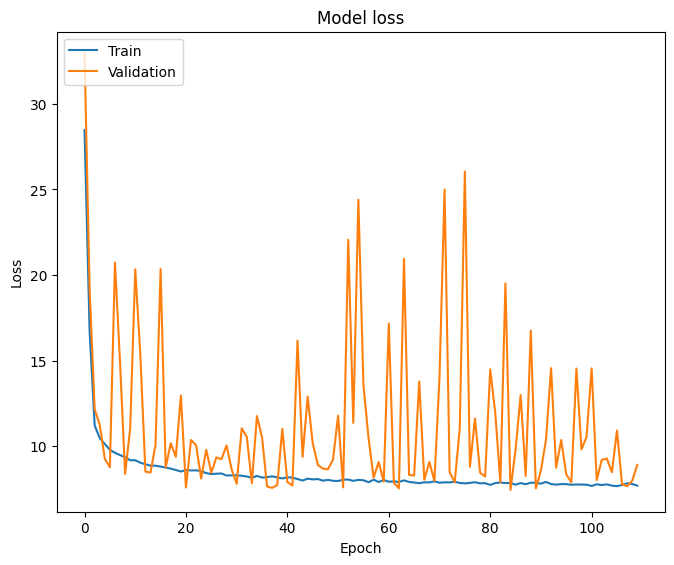

In [27]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1, bottom=0, right=0.95, left=0, hspace=0.25, wspace=0.35)

**Gender Accuracy**

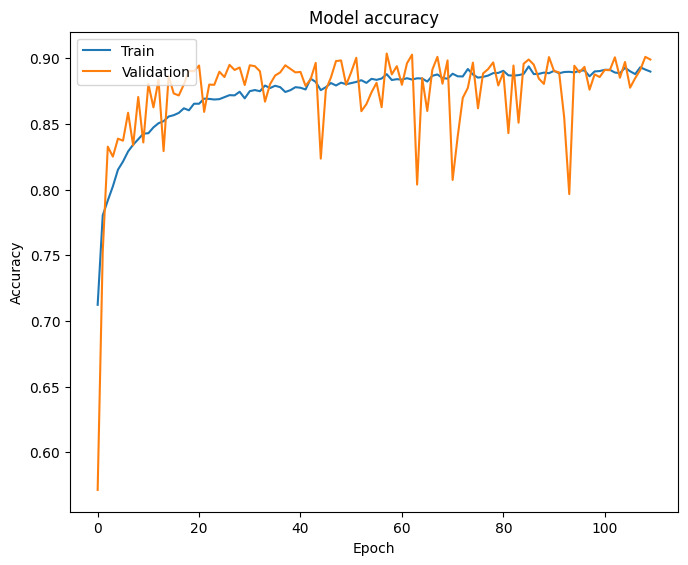

In [28]:
plt.plot(History.history['sex_out_accuracy'])
plt.plot(History.history['val_sex_out_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1, bottom=0, right=0.95, left=0, hspace=0.25, wspace=0.35)

**Age Accuracy**

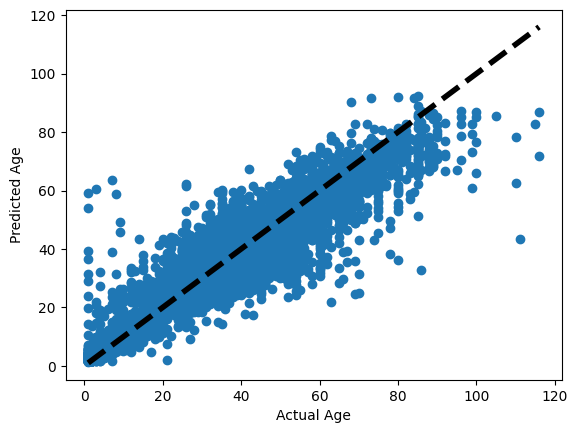

In [29]:
fig, ax = plt.subplots()
ax.scatter(y_test2[1], pred[1])
ax.plot([y_test2[1].min(), y_test2[1].max()], [y_test2[1].min(), y_test2[1].max()], 'k--', lw=4)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age')
plt.show()

## Creating Reports

In [30]:
i = 0
Pred_l = []
while(i < len(pred[0])):
    Pred_l.append(int(np.round(pred[0][i])))
    i += 1

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

report = classification_report(y_test2[0], Pred_l)
results = confusion_matrix(y_test2[0], Pred_l)
print('Classification Report:\n', report)
print('Confusion Matrix:\n', results)

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      3113
           1       0.93      0.85      0.89      2814

    accuracy                           0.90      5927
   macro avg       0.90      0.89      0.89      5927
weighted avg       0.90      0.90      0.90      5927

Confusion Matrix:
 [[2926  187]
 [ 431 2383]]


**Plotting Heatmap**

<Axes: >

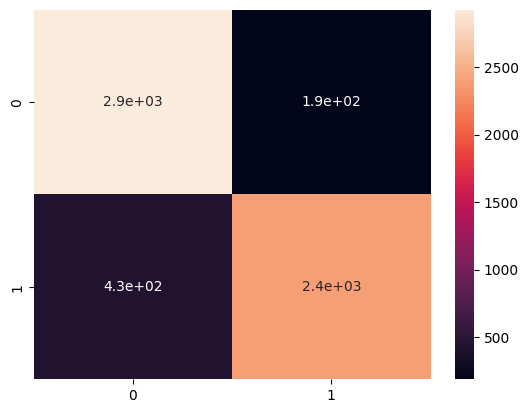

In [32]:
import seaborn as sns

sns.heatmap(results, annot=True)

## Manual Testing of Images

In [33]:
def test_img(ind, images_f, images_f2, model):
    plt.imshow(images_f[ind])
    image_test = images_f2[ind]
    Pred_l2 = model.predict(np.array([image_test]))
    sex_f = ['Male', 'Female']
    age = int(np.round(Pred_l2[1][0]))
    sex = int(np.round(Pred_l2[0][0]))
    print('Predicted Age is: ' + str(age))
    print('Predicted Gender is: ' + sex_f[sex])

1/1 [==============================] - 0s 97ms/step
Predicted Age is: 25
Predicted Gender is: Female


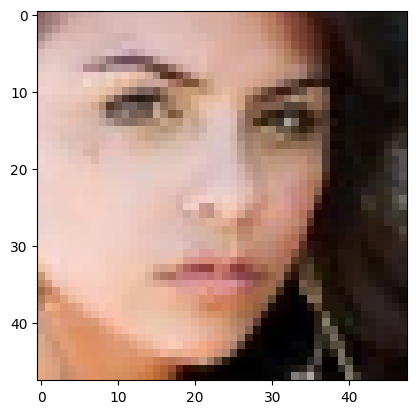

In [34]:
test_img(4, images_f, images_f2, model)

1/1 [==============================] - 0s 19ms/step
Predicted Age is: 31
Predicted Gender is: Male


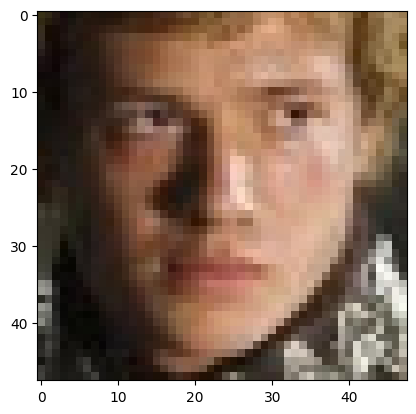

In [35]:
test_img(1288, images_f, images_f2, model)

1/1 [==============================] - 0s 18ms/step
Predicted Age is: 51
Predicted Gender is: Female


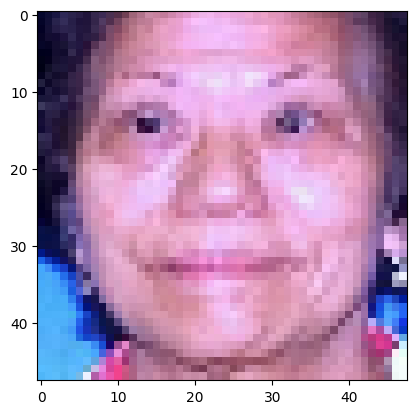

In [36]:
test_img(278, images_f, images_f2, model)

1/1 [==============================] - 0s 19ms/step
Predicted Age is: 9
Predicted Gender is: Male


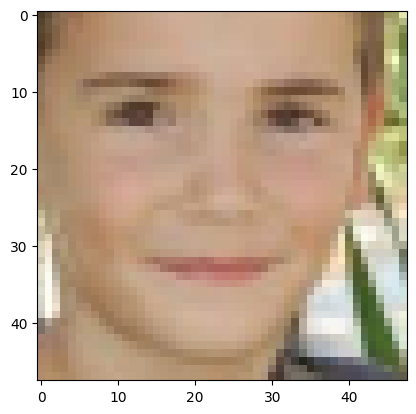

In [37]:
test_img(10902, images_f, images_f2, model)